In [1]:
import torch
from torch.utils.data import DataLoader

from torchvision.transforms import v2

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
from utils.helpers import  plot_some_images ,read_images
from utils.Preprocessing import WhiteTopHat , CLAHE , normalize_xca
from utils.dataset import  UnetDataset
from models.nnunet import nnUnet
from utils.losses import UnetLoss
from utils.recorder import HistoryRecorder
from utils.logger import save_full_report
from trainer import trainer

# Training

In [2]:
args = {
    "base_path" : "../arcade/nnUnet_dataset/syntax",
    "in_c" : 1,
    "base_channel" :32,
    "image_shape" : (512,512),
    "class_count" : 26 ,
    "attention" : True,
    "batch_size" : 10,
    "num_workers" : 10,
    "device" : "cuda" if torch.cuda.is_available() else "cpu",
    "lr" : 0.001,
    "momentum" : 0.9,
    "epcohs":100,
    "f_int_scale" : 2,
    "full_report_cycle" : 10,
    "max_channels":512,
    "input_channels":1,
    "loss_type":"tversky loss",
    "alpha":0.75,
    "beta":0.25,
    "gamma":1.33,
    "output_base_path" : "./outputs",
    "name" : "Attention7-teversky"
}
class_map = {
    0: '1',1: '2', 2: '3',3: '4',
    4: '5',5: '6',6: '7',7: '8',
    8: '9',9: '9a',10: '10',11: '10a',
    12: '11',13: '12',14: '12a',15: '13',
    16: '14',17: '14a',18: '15',19: '16',
    20: '16a',21: '16b',22: '16c',
    23: '12b',24: '14b'
}
losses_keys = ["total loss","CE loss",args["loss_type"]]

In [3]:
train_transforms = A.Compose([
    A.GaussianBlur(
        sigma_limit=[0.1,0.5],
        p=0.5
    ),
    A.RandomBrightnessContrast(
        brightness_limit=0.1,
        contrast_limit=0.15,
        brightness_by_max=True,
        p=0.3
    ),
    A.RandomGamma(
        gamma_limit=(90, 120), 
        p=0.3
    ),
    A.Rotate(limit=15, p=0.3 , fill_mask = 25),
    A.HorizontalFlip(p=0.3),
    A.VerticalFlip(p=0.3),
    A.Lambda(image=normalize_xca),
    ToTensorV2()
])
test_transforms = A.Compose([
    A.Lambda(image=normalize_xca),
    ToTensorV2()
])
# train_preprocess = v2.Compose([
#     WhiteTopHat(kernel_size=(50,50)),
#     CLAHE()
    
# ])
train_preprocess = None

In [4]:

train_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "train")
valid_images = read_images(base_path = args["base_path"],preprocessor = train_preprocess,part = "val")

train_ds = UnetDataset(transform = train_transforms,data = train_images)
valid_ds = UnetDataset(transform = test_transforms,data = valid_images)

train_loader = DataLoader(
    train_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=True
)
valid_loader = DataLoader(
    valid_ds,
    batch_size = args["batch_size"] ,
    num_workers = args["num_workers"] ,
    pin_memory=True,
    shuffle=False,
)

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/1000 [00:00<?, ?it/s]

NOTE : preprocessor is not defined . no preprocessing will be used !


  0%|          | 0/200 [00:00<?, ?it/s]

In [5]:
# plot_some_images(train_images, train_transforms, image_counts=36, fig_shape=(6,6), base_transforms=test_transforms)

In [ ]:
model = nnUnet(args).to(args["device"])
loss_fn = UnetLoss(args)
optimizer = torch.optim.Adam(model.parameters(), lr=args["lr"])
recorder = HistoryRecorder(losses_keys=losses_keys,class_maps =class_map)
trainer(args,recorder,model,optimizer,loss_fn,train_loader,valid_loader)

number of layers : 7
encoder settings :  [32, 64, 128, 256, 512, 512, 512]
bottle-neck settings :  1024
decoder settings :  [1024, 1024, 512, 256, 128, 64]
head settings :  26
loss is set to tversky


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (0)
total loss : 2.8461706042289734 - CE loss : 1.8589327412843704 - tversky loss : 0.9872378611564636

train avg metrics for epoch 0 :
avg dice : 0.006428917823520511 - avg precision : 0.010092113824284751 - avg recall : 0.01701759058909374
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (0)
total loss : 1.7968923151493073 - CE loss : 0.8128902643918992 - tversky loss : 0.9840020656585693

valid avg metrics for epoch 0 :
avg dice : 0.011266903249313696 - avg precision : 0.024062237739562987 - avg recall : 0.013235782745905453
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (1)
total loss : 1.3948883664608003 - CE loss : 0.44072273433208464 - tversky loss : 0.9541656357049942

train avg metrics for epoch 1 :
avg dice : 0.013746297415093912 - avg precision : 0.02523706793785095 - avg recall : 0.020712610066475463
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (1)
total loss : 1.1996076226234436 - CE loss : 0.26722416207194327 - tversky loss : 0.9323834598064422

valid avg metrics for epoch 1 :
avg dice : 0.013210497803928058 - avg precision : 0.028994099199771882 - avg recall : 0.02563266407814808
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (2)
total loss : 1.0795813250541686 - CE loss : 0.20777536556124687 - tversky loss : 0.8718059539794922

train avg metrics for epoch 2 :
avg dice : 0.04120526456318332 - avg precision : 0.04605317503213882 - avg recall : 0.04791400509770028
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (2)
total loss : 1.0189110100269319 - CE loss : 0.18458777144551278 - tversky loss : 0.834323251247406

valid avg metrics for epoch 2 :
avg dice : 0.057718651462747524 - avg precision : 0.06526115119457244 - avg recall : 0.0693348731007427
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (3)
total loss : 0.9195091998577118 - CE loss : 0.16414433747529983 - tversky loss : 0.755364859700203

train avg metrics for epoch 3 :
avg dice : 0.08270287036939646 - avg precision : 0.09499630838632583 - avg recall : 0.08710881549865007
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (3)
total loss : 0.8728009790182114 - CE loss : 0.167661339789629 - tversky loss : 0.7051396310329437

valid avg metrics for epoch 3 :
avg dice : 0.12646563082971926 - avg precision : 0.13624572783708572 - avg recall : 0.1261151061952114
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (4)
total loss : 0.7980879408121109 - CE loss : 0.15002275206148624 - tversky loss : 0.6480651867389678

train avg metrics for epoch 4 :
avg dice : 0.12616766035600657 - avg precision : 0.12679310083389284 - avg recall : 0.1294836761057377
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (4)
total loss : 0.8287158757448196 - CE loss : 0.16321532428264618 - tversky loss : 0.665500545501709

valid avg metrics for epoch 4 :
avg dice : 0.1262215315554373 - avg precision : 0.15969247594475747 - avg recall : 0.12818503189831973
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (5)
total loss : 0.7153905463218689 - CE loss : 0.13981724746525287 - tversky loss : 0.5755732971429824

train avg metrics for epoch 5 :
avg dice : 0.15660824168517262 - avg precision : 0.16032633125782014 - avg recall : 0.1615428140759468
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (5)
total loss : 0.7649817258119583 - CE loss : 0.158212810754776 - tversky loss : 0.60676891207695

valid avg metrics for epoch 5 :
avg dice : 0.15983630394134526 - avg precision : 0.1877161854505539 - avg recall : 0.16131506210018415
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (6)
total loss : 0.6591183391213417 - CE loss : 0.13320055961608887 - tversky loss : 0.5259177795052529

train avg metrics for epoch 6 :
avg dice : 0.17889568794635202 - avg precision : 0.1825451286882162 - avg recall : 0.18365540662991406
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (6)
total loss : 0.680860635638237 - CE loss : 0.14088107645511627 - tversky loss : 0.5399795636534691

valid avg metrics for epoch 6 :
avg dice : 0.1960223235379889 - avg precision : 0.21561503350734712 - avg recall : 0.19103572744876146
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (7)
total loss : 0.6113331940770149 - CE loss : 0.12628153204917908 - tversky loss : 0.4850516626238823

train avg metrics for epoch 7 :
avg dice : 0.19899370705985184 - avg precision : 0.20372898168861867 - avg recall : 0.20347036667400972
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (7)
total loss : 0.6962735503911972 - CE loss : 0.1470556803047657 - tversky loss : 0.5492178618907928

valid avg metrics for epoch 7 :
avg dice : 0.1941187849155612 - avg precision : 0.2062285253405571 - avg recall : 0.19458343521720964
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (8)
total loss : 0.5999637538194657 - CE loss : 0.12511327363550662 - tversky loss : 0.4748504817485809

train avg metrics for epoch 8 :
avg dice : 0.20603660291569695 - avg precision : 0.21050938919186593 - avg recall : 0.21041201518848537
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (8)
total loss : 0.6745981782674789 - CE loss : 0.1445599678903818 - tversky loss : 0.5300382107496262

valid avg metrics for epoch 8 :
avg dice : 0.20327211921255678 - avg precision : 0.2268971860408783 - avg recall : 0.1966815869718266
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (9)
total loss : 0.5895690575242043 - CE loss : 0.12447019696235656 - tversky loss : 0.4650988593697548

train avg metrics for epoch 9 :
avg dice : 0.21113009842970548 - avg precision : 0.2241205593943596 - avg recall : 0.2158351597022556
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (9)
total loss : 0.6146097540855407 - CE loss : 0.13174287043511868 - tversky loss : 0.48286688327789307

valid avg metrics for epoch 9 :
avg dice : 0.22998372369538544 - avg precision : 0.2534336368739605 - avg recall : 0.2214990965242032
1 => dice : 0.66404789686203 p : 0.8076285123825073 , r : 0.5638129115104675
2 => dice : 0.6142378449440002 p : 0.676259458065033 , r : 0.5626368522644043
3 => dice : 0.5942996144294739 p : 0.6117987036705017 , r : 0.5777738094329834
4 => dice : 0.355123907327652 p : 0.3828409016132355 , r : 0.33114930987358093
5 => dice : 0.6475649476051331 p : 0.728538453578949 , r : 0.5827905535697937
6 => dice : 0.5294440388679504 p : 0.

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (10)
total loss : 0.5557721063494683 - CE loss : 0.11925124295055867 - tversky loss : 0.4365208637714386

train avg metrics for epoch 10 :
avg dice : 0.2267950450437512 - avg precision : 0.23892464969307184 - avg recall : 0.2294626663107192
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (10)
total loss : 0.615037202835083 - CE loss : 0.13372452035546303 - tversky loss : 0.48131268173456193

valid avg metrics for epoch 10 :
avg dice : 0.23373907024774143 - avg precision : 0.27234278075397017 - avg recall : 0.22601987837231718
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (11)
total loss : 0.5295322287082672 - CE loss : 0.11514725901186466 - tversky loss : 0.4143849715590477

train avg metrics for epoch 11 :
avg dice : 0.2425513035223251 - avg precision : 0.25641178764402867 - avg recall : 0.24274086807359707
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (11)
total loss : 0.6286228686571121 - CE loss : 0.13542999215424062 - tversky loss : 0.49319287538528445

valid avg metrics for epoch 11 :
avg dice : 0.2273029455346577 - avg precision : 0.25233832344412804 - avg recall : 0.22415348152477235
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (12)
total loss : 0.5408341699838638 - CE loss : 0.11787714213132858 - tversky loss : 0.4229570266604423

train avg metrics for epoch 12 :
avg dice : 0.23879179789406368 - avg precision : 0.2560703695565462 - avg recall : 0.2400159270731092
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (12)
total loss : 0.5895644545555114 - CE loss : 0.13155732117593288 - tversky loss : 0.45800713151693345

valid avg metrics for epoch 12 :
avg dice : 0.24788111909082727 - avg precision : 0.2824550452828407 - avg recall : 0.2332976946630515
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (13)
total loss : 0.5322249010205269 - CE loss : 0.11696878924965859 - tversky loss : 0.41525611221790315

train avg metrics for epoch 13 :
avg dice : 0.24404386039894443 - avg precision : 0.2538667542859912 - avg recall : 0.24381750746644684
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (13)
total loss : 0.5948044717311859 - CE loss : 0.13055916391313077 - tversky loss : 0.46424531042575834

valid avg metrics for epoch 13 :
avg dice : 0.2509895286577111 - avg precision : 0.27571204722858966 - avg recall : 0.24352529319781752
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (14)
total loss : 0.49469670206308364 - CE loss : 0.10928945139050483 - tversky loss : 0.3854072472453117

train avg metrics for epoch 14 :
avg dice : 0.26311374062597886 - avg precision : 0.27517457991838457 - avg recall : 0.26221832063631156
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (14)
total loss : 0.5737441495060921 - CE loss : 0.1295836389064789 - tversky loss : 0.44416051357984543

valid avg metrics for epoch 14 :
avg dice : 0.25929417898435714 - avg precision : 0.2864763422124088 - avg recall : 0.25029018193949015
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (15)
total loss : 0.49595042914152143 - CE loss : 0.11103536732494831 - tversky loss : 0.3849150612950325

train avg metrics for epoch 15 :
avg dice : 0.26185046489792474 - avg precision : 0.2726871544867754 - avg recall : 0.26066475238389103
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (15)
total loss : 0.5701625317335128 - CE loss : 0.12443608045578003 - tversky loss : 0.44572644531726835

valid avg metrics for epoch 15 :
avg dice : 0.26103245280716475 - avg precision : 0.29326617643237113 - avg recall : 0.2535981143359095
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (16)
total loss : 0.486909254193306 - CE loss : 0.10978489771485328 - tversky loss : 0.3771243545413017

train avg metrics for epoch 16 :
avg dice : 0.26982561923605525 - avg precision : 0.2820901194214821 - avg recall : 0.2672811351157725
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (16)
total loss : 0.6064152091741561 - CE loss : 0.13511827476322652 - tversky loss : 0.47129693180322646

valid avg metrics for epoch 16 :
avg dice : 0.24430273480736284 - avg precision : 0.2681434899568558 - avg recall : 0.24263198602944613
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (17)
total loss : 0.4912039318680763 - CE loss : 0.1103956800699234 - tversky loss : 0.38080825239419935

train avg metrics for epoch 17 :
avg dice : 0.2675644548986586 - avg precision : 0.281313593685627 - avg recall : 0.26575160373002293
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (17)
total loss : 0.5789641737937927 - CE loss : 0.12709777876734735 - tversky loss : 0.4518663987517357

valid avg metrics for epoch 17 :
avg dice : 0.25615165512798915 - avg precision : 0.28854394420981405 - avg recall : 0.23895336187291832
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (18)
total loss : 0.478023017346859 - CE loss : 0.10848607055842877 - tversky loss : 0.36953694850206376

train avg metrics for epoch 18 :
avg dice : 0.2746599511728079 - avg precision : 0.29127850957214835 - avg recall : 0.2723624400224071
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (18)
total loss : 0.5686807498335839 - CE loss : 0.12608592510223388 - tversky loss : 0.4425948172807693

valid avg metrics for epoch 18 :
avg dice : 0.2660796077441006 - avg precision : 0.31353423483669757 - avg recall : 0.2559059929047362
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (19)
total loss : 0.4646550962328911 - CE loss : 0.10554886944591998 - tversky loss : 0.35910622611641885

train avg metrics for epoch 19 :
avg dice : 0.2847954733371177 - avg precision : 0.3060826808586717 - avg recall : 0.2823062005965039
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (19)
total loss : 0.5510261297225952 - CE loss : 0.12413486503064633 - tversky loss : 0.42689125835895536

valid avg metrics for epoch 19 :
avg dice : 0.2761002069713977 - avg precision : 0.30607145771384237 - avg recall : 0.26596594337373974
1 => dice : 0.7118380665779114 p : 0.7415100336074829 , r : 0.6844494938850403
2 => dice : 0.6385465264320374 p : 0.6755759716033936 , r : 0.6053654551506042
3 => dice : 0.6188955307006836 p : 0.6321810483932495 , r : 0.6061568856239319
4 => dice : 0.4624660909175873 p : 0.4843595623970032 , r : 0.44246622920036316
5 => dice : 0.6505118012428284 p : 0.7658278942108154 , r : 0.565378725528717
6 => dice : 0.56526607275009

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (20)
total loss : 0.47078600496053696 - CE loss : 0.10772528097033501 - tversky loss : 0.3630607223510742

train avg metrics for epoch 20 :
avg dice : 0.28480607036832567 - avg precision : 0.3065672081708908 - avg recall : 0.280855920762624
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (20)
total loss : 0.5575760111212731 - CE loss : 0.12268158346414566 - tversky loss : 0.4348944306373596

valid avg metrics for epoch 20 :
avg dice : 0.27946964532159835 - avg precision : 0.3135610668361187 - avg recall : 0.2661527828127146
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (21)
total loss : 0.45554278790950775 - CE loss : 0.10389018543064595 - tversky loss : 0.3516526015102863

train avg metrics for epoch 21 :
avg dice : 0.2957450398617618 - avg precision : 0.3177009724080563 - avg recall : 0.2909003743052017
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (21)
total loss : 0.5495328068733215 - CE loss : 0.12547507844865322 - tversky loss : 0.42405773252248763

valid avg metrics for epoch 21 :
avg dice : 0.27877634145284946 - avg precision : 0.31539351949468253 - avg recall : 0.2638003195245983
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (22)
total loss : 0.4464894723892212 - CE loss : 0.10288606651127338 - tversky loss : 0.34360340565443037

train avg metrics for epoch 22 :
avg dice : 0.2977413437892087 - avg precision : 0.3132212473452091 - avg recall : 0.2944936171360314
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (22)
total loss : 0.5460816815495491 - CE loss : 0.1203719899058342 - tversky loss : 0.4257096886634827

valid avg metrics for epoch 22 :
avg dice : 0.28261583901961673 - avg precision : 0.3242873078584671 - avg recall : 0.2687845661863685
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (23)
total loss : 0.43393822103738783 - CE loss : 0.10080924108624459 - tversky loss : 0.33312897995114327

train avg metrics for epoch 23 :
avg dice : 0.30617471607209495 - avg precision : 0.3249014738947153 - avg recall : 0.302934494948131
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (23)
total loss : 0.537989541888237 - CE loss : 0.1262481540441513 - tversky loss : 0.4117413878440857

valid avg metrics for epoch 23 :
avg dice : 0.2907485249640655 - avg precision : 0.34221558332443236 - avg recall : 0.27153707491233947
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (24)
total loss : 0.4346738764643669 - CE loss : 0.10133451551198959 - tversky loss : 0.33333936125040053

train avg metrics for epoch 24 :
avg dice : 0.30803351486258523 - avg precision : 0.3246072778105736 - avg recall : 0.303590321969823
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (24)
total loss : 0.5228614807128906 - CE loss : 0.11922508403658867 - tversky loss : 0.40363639295101167

valid avg metrics for epoch 24 :
avg dice : 0.30409813702124466 - avg precision : 0.32447690367698667 - avg recall : 0.29771657660603523
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (25)
total loss : 0.42157932341098786 - CE loss : 0.0991172395646572 - tversky loss : 0.3224620819091797

train avg metrics for epoch 25 :
avg dice : 0.3193925022110876 - avg precision : 0.3332503859698772 - avg recall : 0.3146441892566509
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (25)
total loss : 0.5193963885307312 - CE loss : 0.11740993224084377 - tversky loss : 0.4019864544272423

valid avg metrics for epoch 25 :
avg dice : 0.2970479114169192 - avg precision : 0.3258294127881527 - avg recall : 0.28417390906251966
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (26)
total loss : 0.41150369614362714 - CE loss : 0.09697644121944904 - tversky loss : 0.31452725514769553

train avg metrics for epoch 26 :
avg dice : 0.3290797429302977 - avg precision : 0.3498324041068554 - avg recall : 0.3225615090772044
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (26)
total loss : 0.5116692438721657 - CE loss : 0.11866206265985965 - tversky loss : 0.3930071771144867

valid avg metrics for epoch 26 :
avg dice : 0.31231134161371105 - avg precision : 0.342463515996933 - avg recall : 0.2955770019441843
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (27)
total loss : 0.4157329699397087 - CE loss : 0.09751948248595 - tversky loss : 0.31821348786354064

train avg metrics for epoch 27 :
avg dice : 0.3277319279555734 - avg precision : 0.35100071450695397 - avg recall : 0.32223411846345695
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (27)
total loss : 0.5291862443089486 - CE loss : 0.11870009787380695 - tversky loss : 0.41048614382743837

valid avg metrics for epoch 27 :
avg dice : 0.29713826671269944 - avg precision : 0.36180982261896133 - avg recall : 0.2761625787243247
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (28)
total loss : 0.39939982518553735 - CE loss : 0.09435761377215385 - tversky loss : 0.30504221200942994

train avg metrics for epoch 28 :
avg dice : 0.3408065702985434 - avg precision : 0.3716100746393204 - avg recall : 0.33330249096266923
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (28)
total loss : 0.5059826582670212 - CE loss : 0.11513140238821507 - tversky loss : 0.39085126370191575

valid avg metrics for epoch 28 :
avg dice : 0.31385322351955514 - avg precision : 0.3590221015363932 - avg recall : 0.2893706267839298
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (29)
total loss : 0.4066018235683441 - CE loss : 0.09614999242126941 - tversky loss : 0.3104518307745457

train avg metrics for epoch 29 :
avg dice : 0.33605592988470306 - avg precision : 0.36526640728116033 - avg recall : 0.3295085331052542
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (29)
total loss : 0.5320188298821449 - CE loss : 0.1204445168375969 - tversky loss : 0.41157431304454806

valid avg metrics for epoch 29 :
avg dice : 0.310072933733643 - avg precision : 0.3238821205496788 - avg recall : 0.30956399291753767
1 => dice : 0.7162799835205078 p : 0.7191342115402222 , r : 0.7134482860565186
2 => dice : 0.6708345413208008 p : 0.6757301092147827 , r : 0.6660093665122986
3 => dice : 0.6336799263954163 p : 0.7154645323753357 , r : 0.5686748623847961
4 => dice : 0.4841834306716919 p : 0.4242510199546814 , r : 0.5638343095779419
5 => dice : 0.6205524802207947 p : 0.7836424112319946 , r : 0.5136522650718689
6 => dice : 0.5482155680656433

  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (30)
total loss : 0.4166963994503021 - CE loss : 0.09882325135171413 - tversky loss : 0.3178731486201286

train avg metrics for epoch 30 :
avg dice : 0.3327902897823913 - avg precision : 0.35020840883255006 - avg recall : 0.3260506438836455
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (30)
total loss : 0.5070062786340713 - CE loss : 0.11292064450681209 - tversky loss : 0.3940856337547302

valid avg metrics for epoch 30 :
avg dice : 0.3154314496183607 - avg precision : 0.37144853949546813 - avg recall : 0.297983442209661
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (31)
total loss : 0.4004671385884285 - CE loss : 0.09453326925635337 - tversky loss : 0.30593386948108675

train avg metrics for epoch 31 :
avg dice : 0.339268380704259 - avg precision : 0.3583830749243498 - avg recall : 0.33305435431888325
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (31)
total loss : 0.49994784891605376 - CE loss : 0.11368844844400883 - tversky loss : 0.38625939935445786

valid avg metrics for epoch 31 :
avg dice : 0.3219667707292199 - avg precision : 0.3812304836511612 - avg recall : 0.30579736035782845
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (32)
total loss : 0.3803197646141052 - CE loss : 0.0911094906181097 - tversky loss : 0.28921027436852453

train avg metrics for epoch 32 :
avg dice : 0.35509252445811174 - avg precision : 0.3792251289635897 - avg recall : 0.3490422531799413
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (32)
total loss : 0.4903839245438576 - CE loss : 0.11106110587716103 - tversky loss : 0.3793228164315224

valid avg metrics for epoch 32 :
avg dice : 0.3323805670179319 - avg precision : 0.3805379528552294 - avg recall : 0.3232101538340794
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (33)
total loss : 0.3724324090778828 - CE loss : 0.08962152268737554 - tversky loss : 0.28281088411808014

train avg metrics for epoch 33 :
avg dice : 0.36091603847257714 - avg precision : 0.3852362057566643 - avg recall : 0.3530347071681172
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (33)
total loss : 0.4862561747431755 - CE loss : 0.11088224612176419 - tversky loss : 0.3753739304840565

valid avg metrics for epoch 33 :
avg dice : 0.33814555499714233 - avg precision : 0.37447001844644545 - avg recall : 0.32761697949841617
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (34)
total loss : 0.3699609291553497 - CE loss : 0.08947816848754883 - tversky loss : 0.28048275902867315

train avg metrics for epoch 34 :
avg dice : 0.36627401165701373 - avg precision : 0.39491951406002046 - avg recall : 0.3586247584503144
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (34)
total loss : 0.48552258759737016 - CE loss : 0.11015407629311084 - tversky loss : 0.3753685101866722

valid avg metrics for epoch 34 :
avg dice : 0.340348017402146 - avg precision : 0.38706050187349317 - avg recall : 0.3223321898840368
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

train ==> epcoh (35)
total loss : 0.3660387849807739 - CE loss : 0.08880640044808388 - tversky loss : 0.27723238602280614

train avg metrics for epoch 35 :
avg dice : 0.37294473126567823 - avg precision : 0.39993221551179886 - avg recall : 0.3634957022219896
<=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=><=>
valid ==> epcoh (35)
total loss : 0.48219422399997713 - CE loss : 0.11020923256874085 - tversky loss : 0.3719849944114685

valid avg metrics for epoch 35 :
avg dice : 0.3447375360691114 - avg precision : 0.3694837811589241 - avg recall : 0.3424651863798499
------------------------------------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]

Saving Memory
Saving All Plots
Saving Examples


  0%|          | 0/18 [00:00<?, ?it/s]

Saving Verbal Results
Copying Notebook To Results


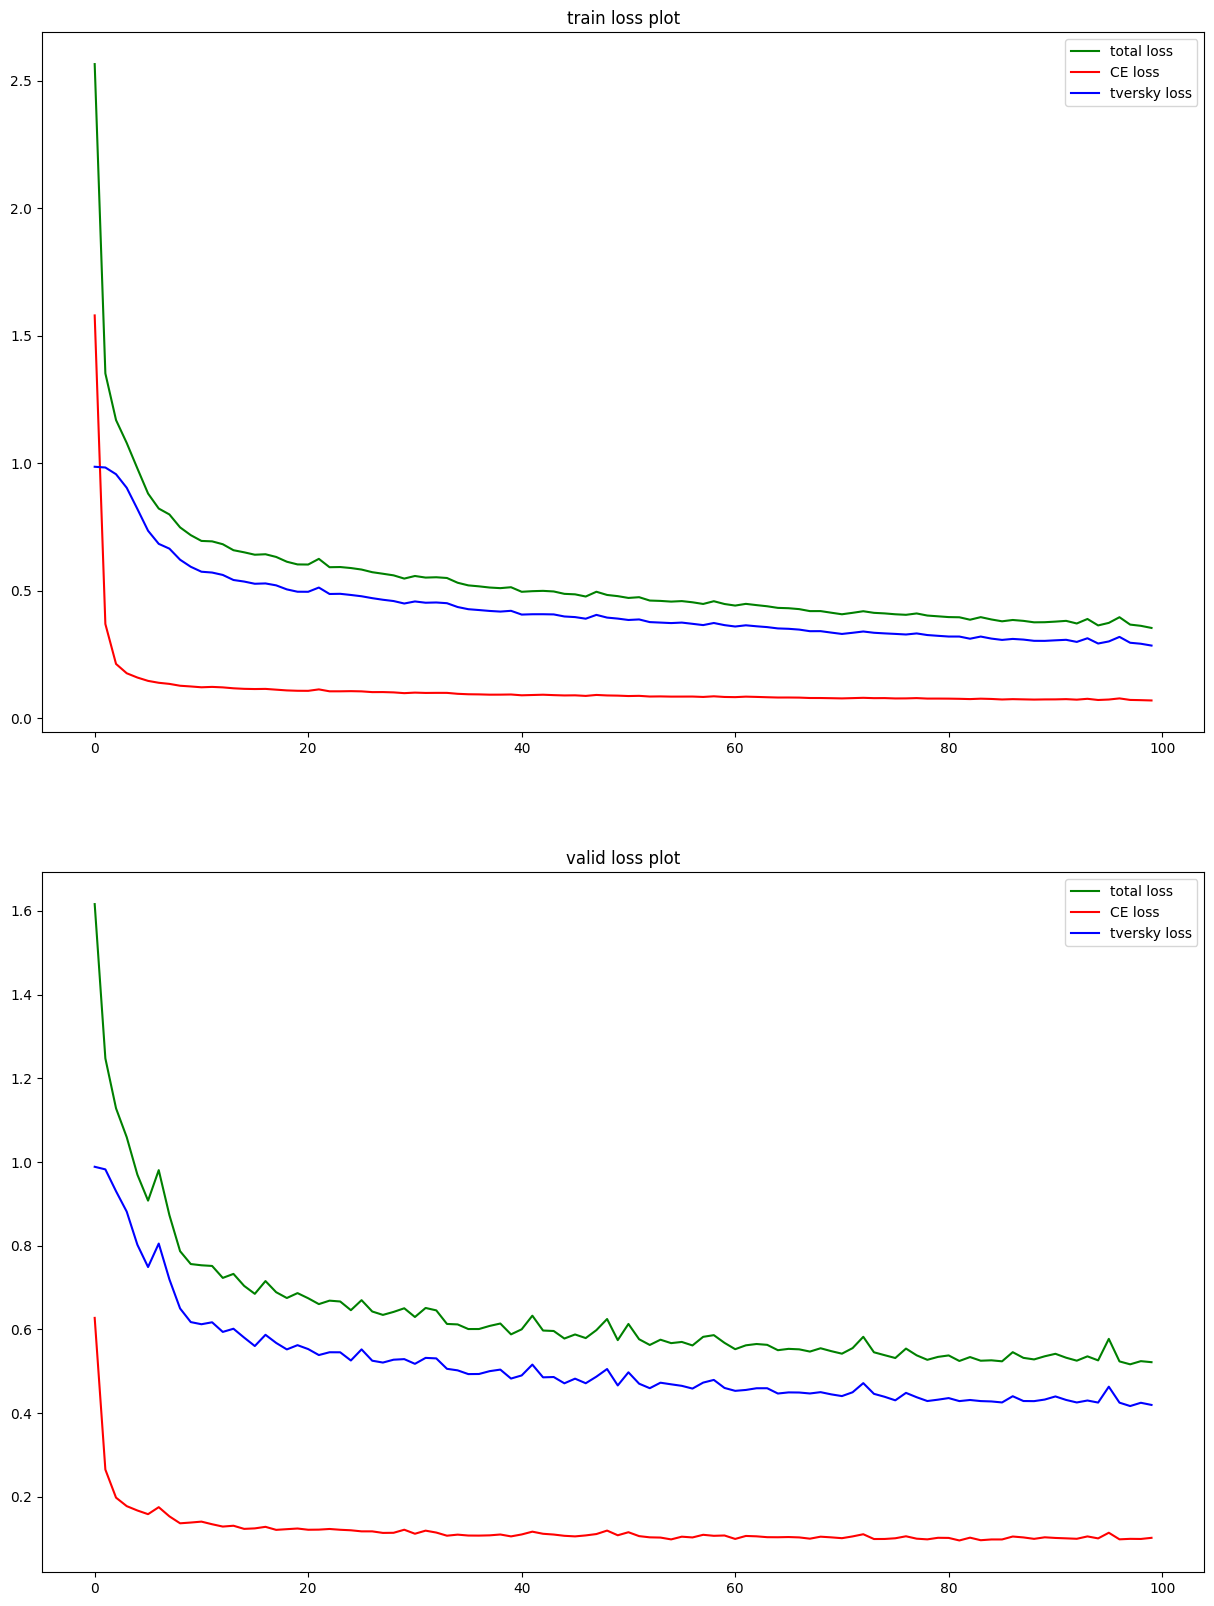

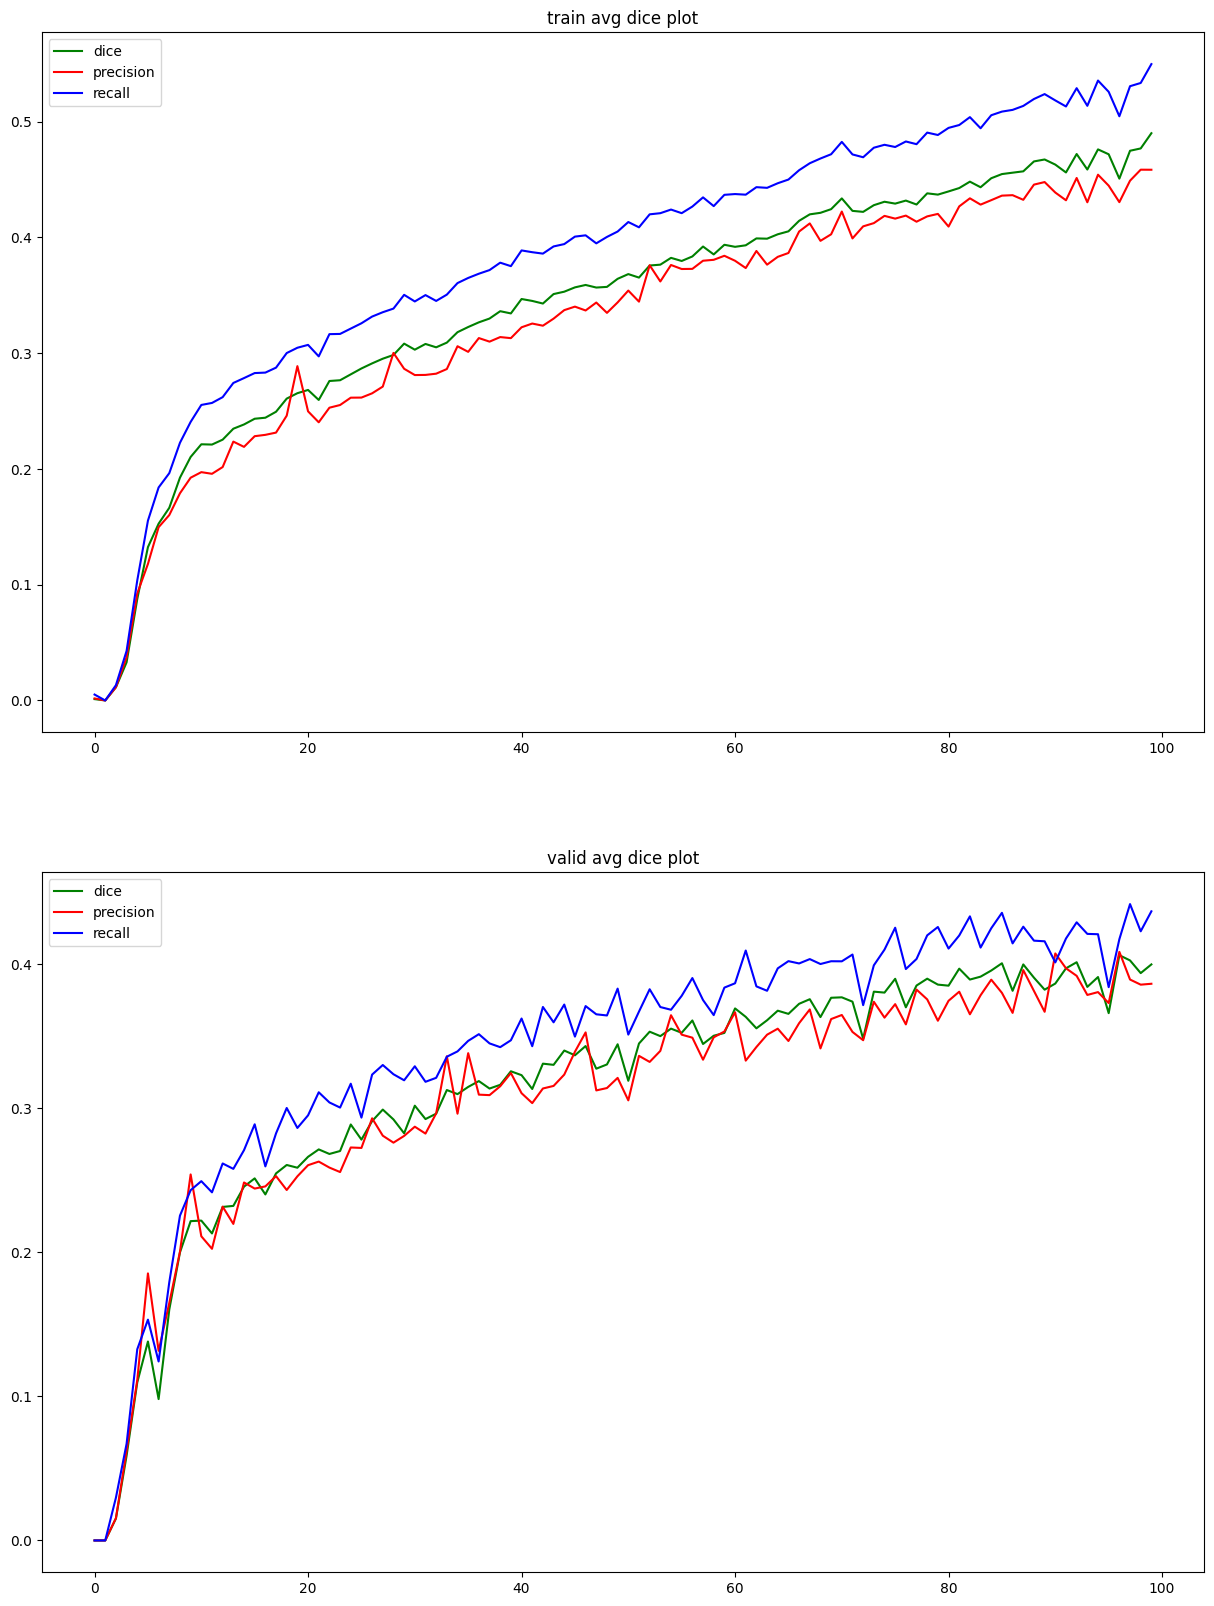

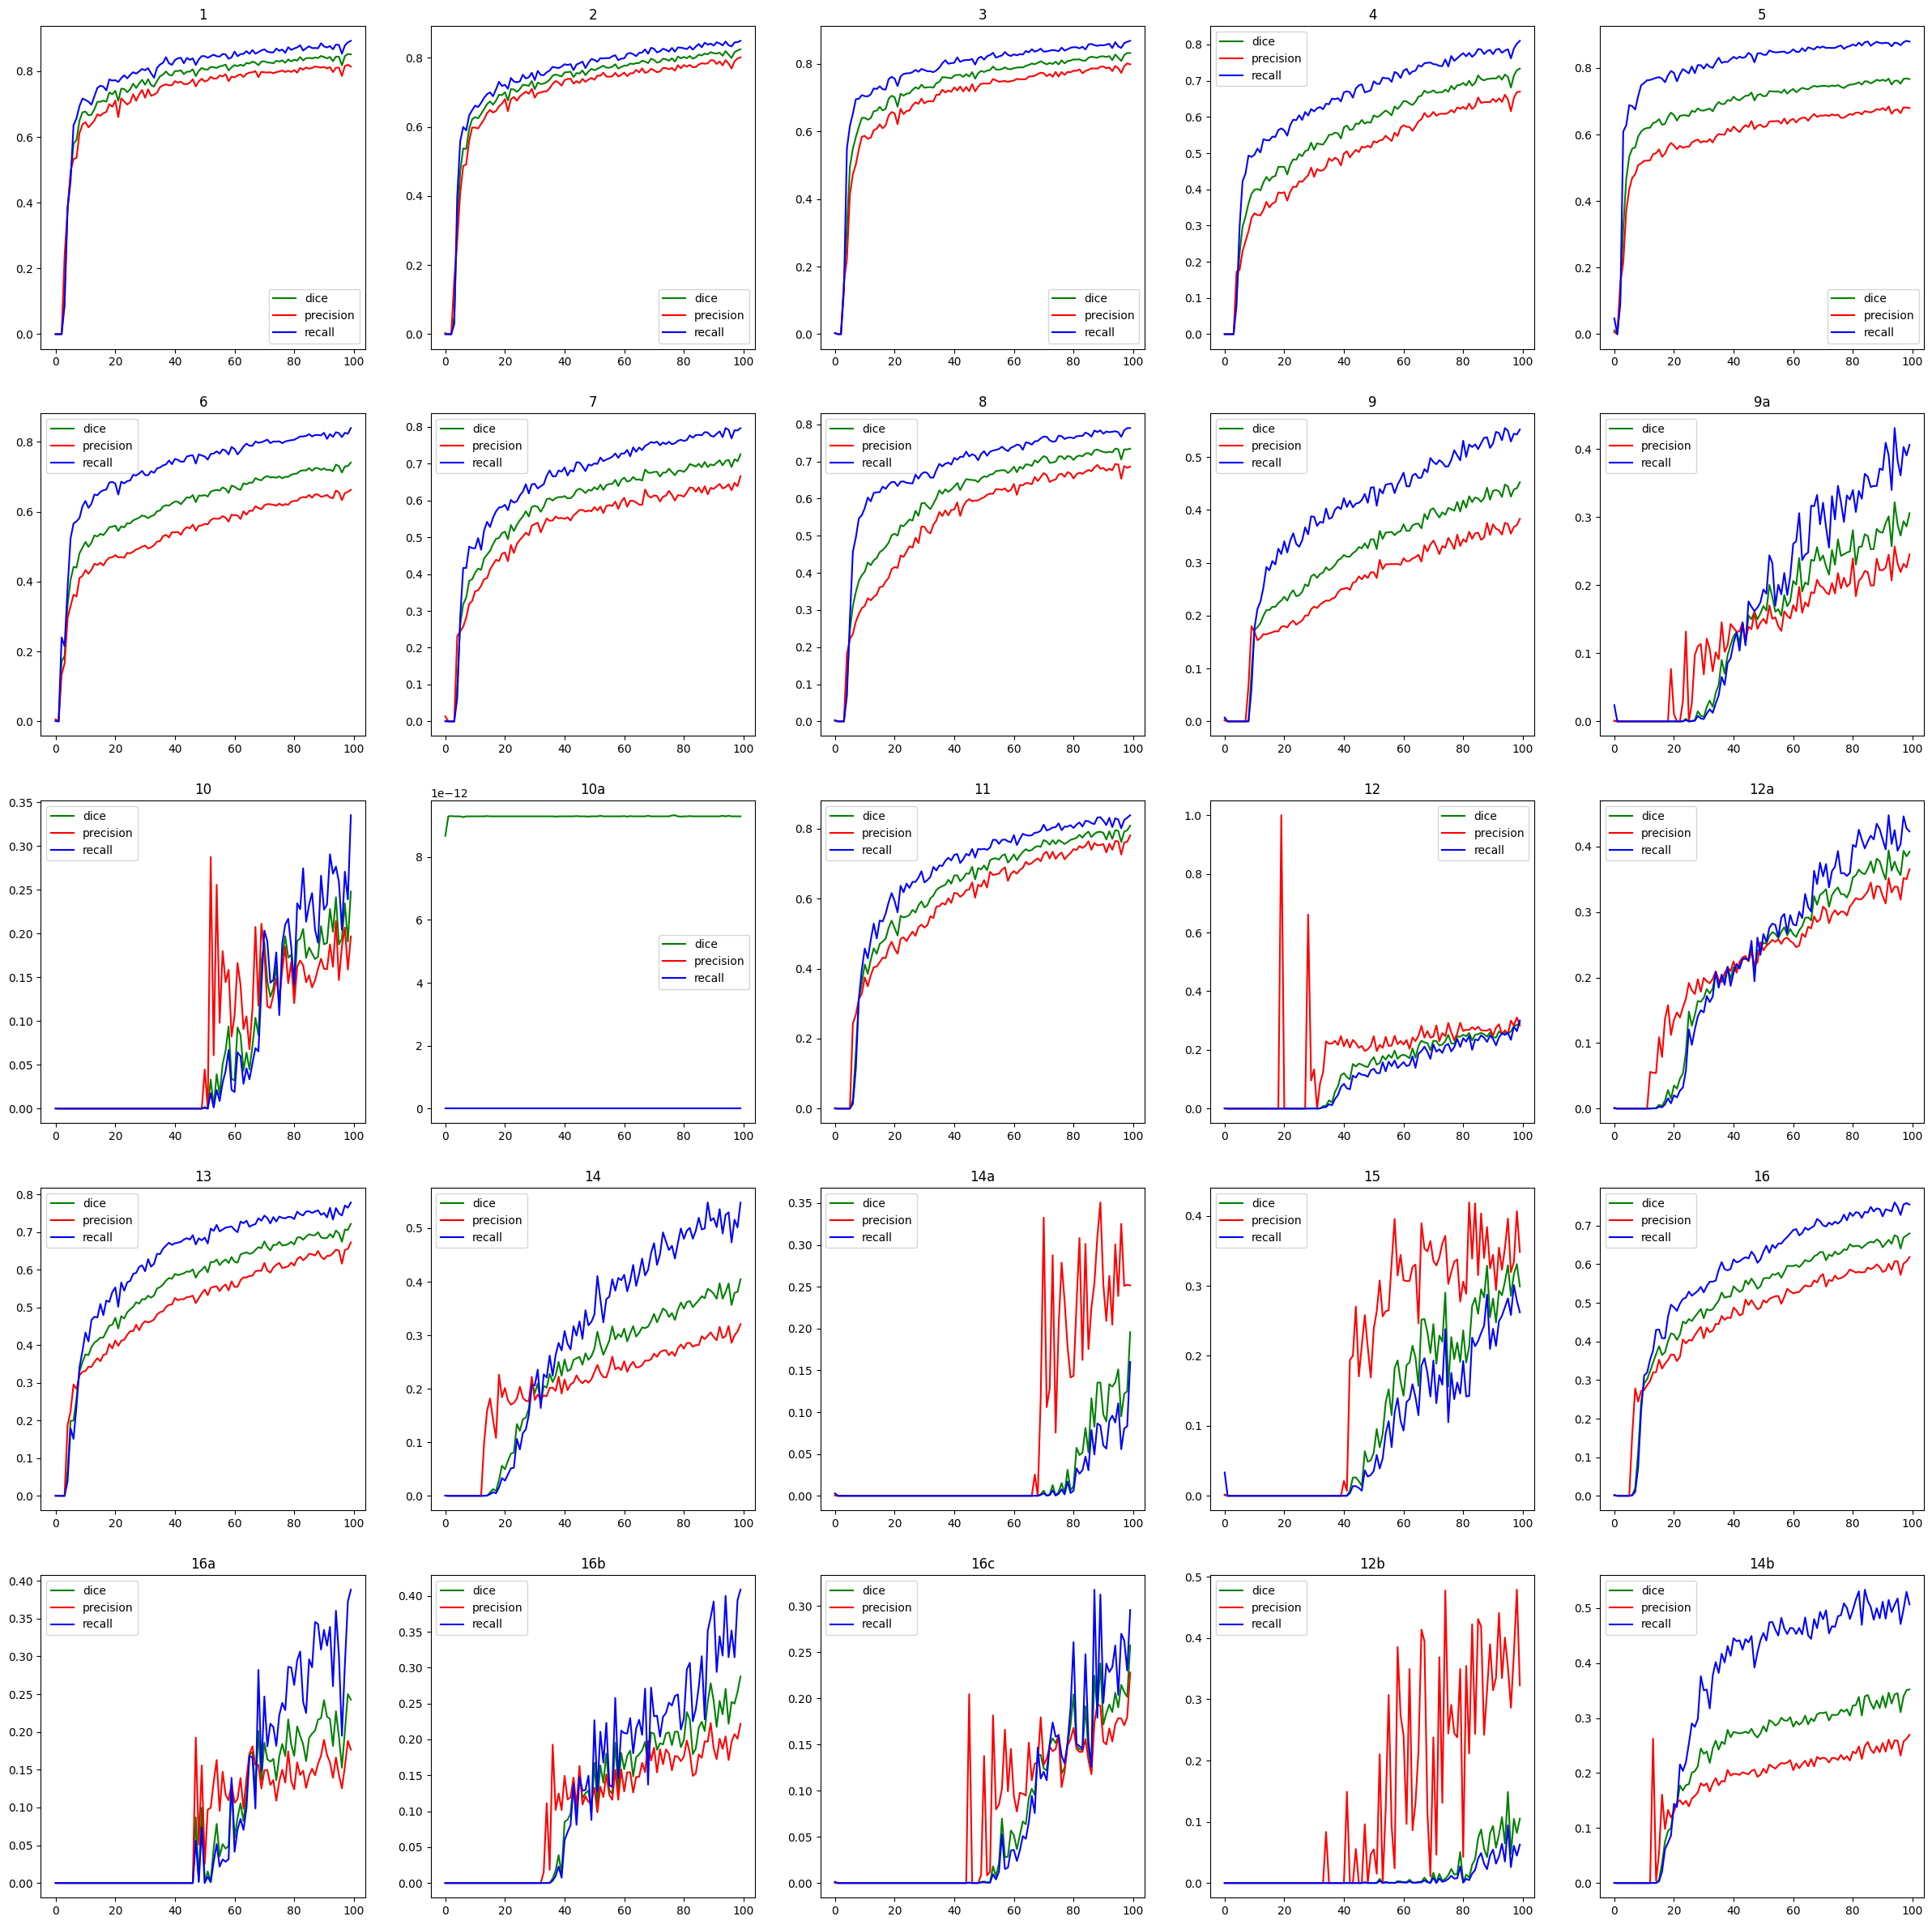

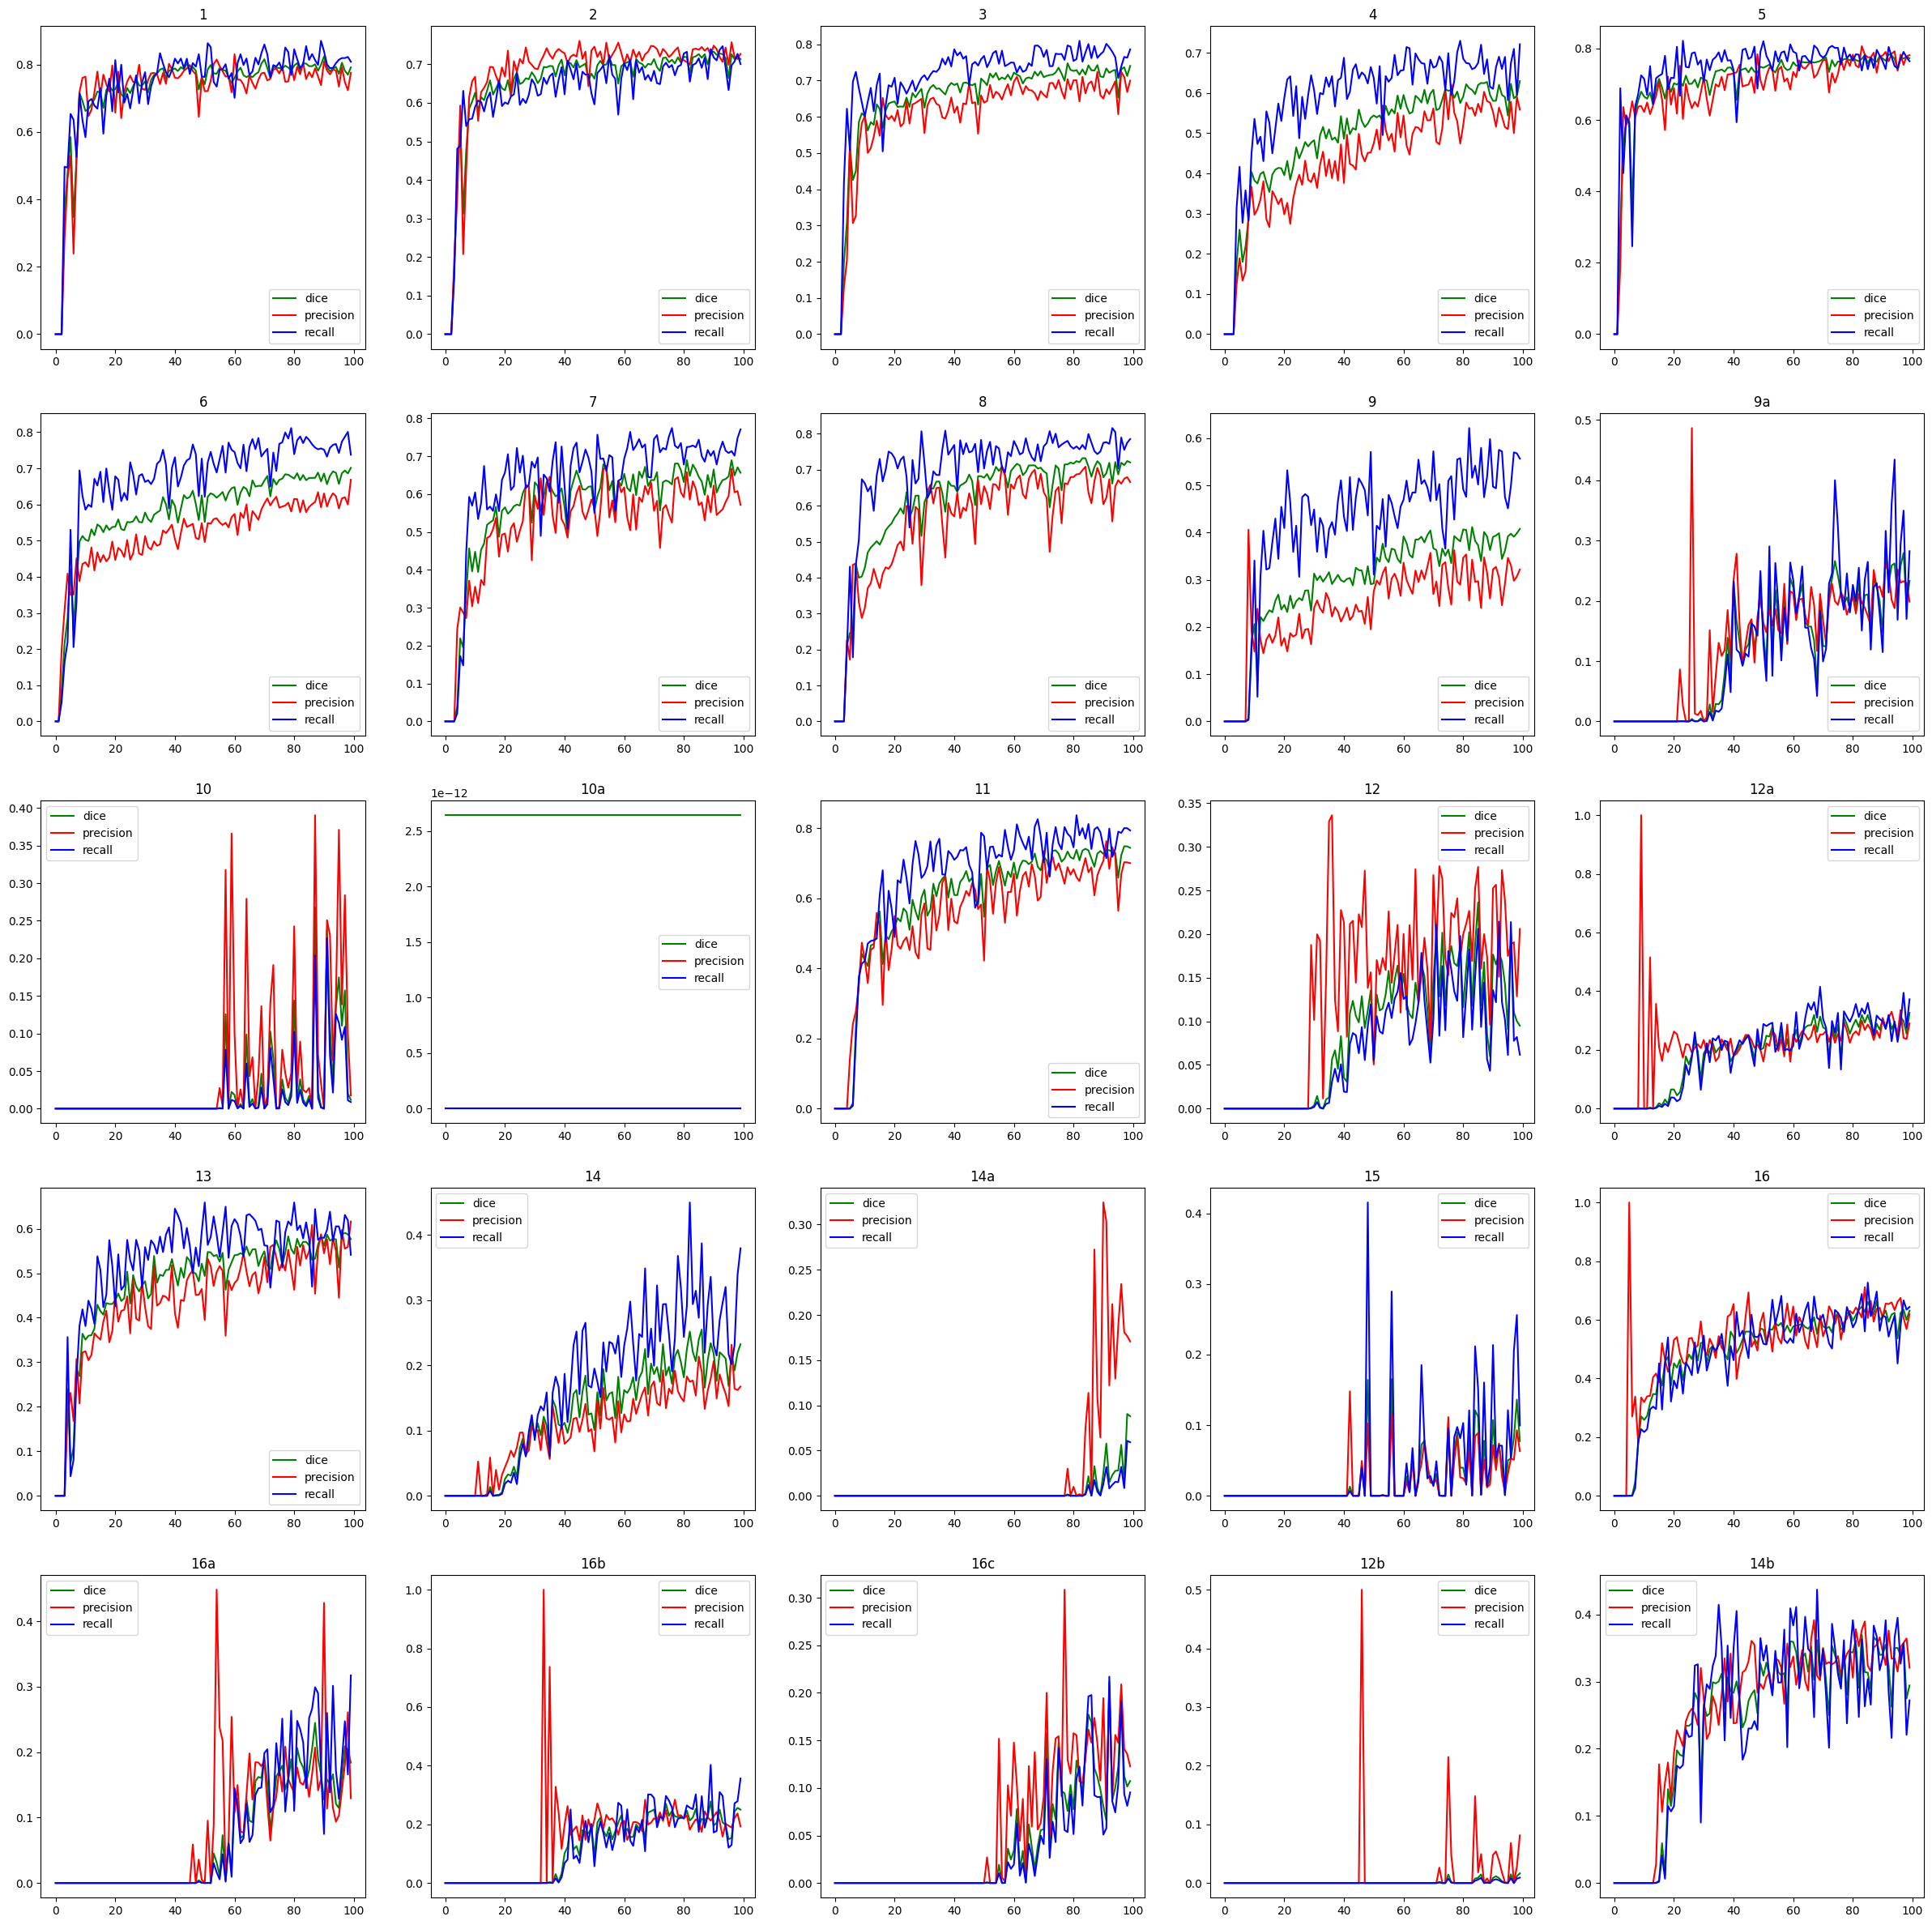

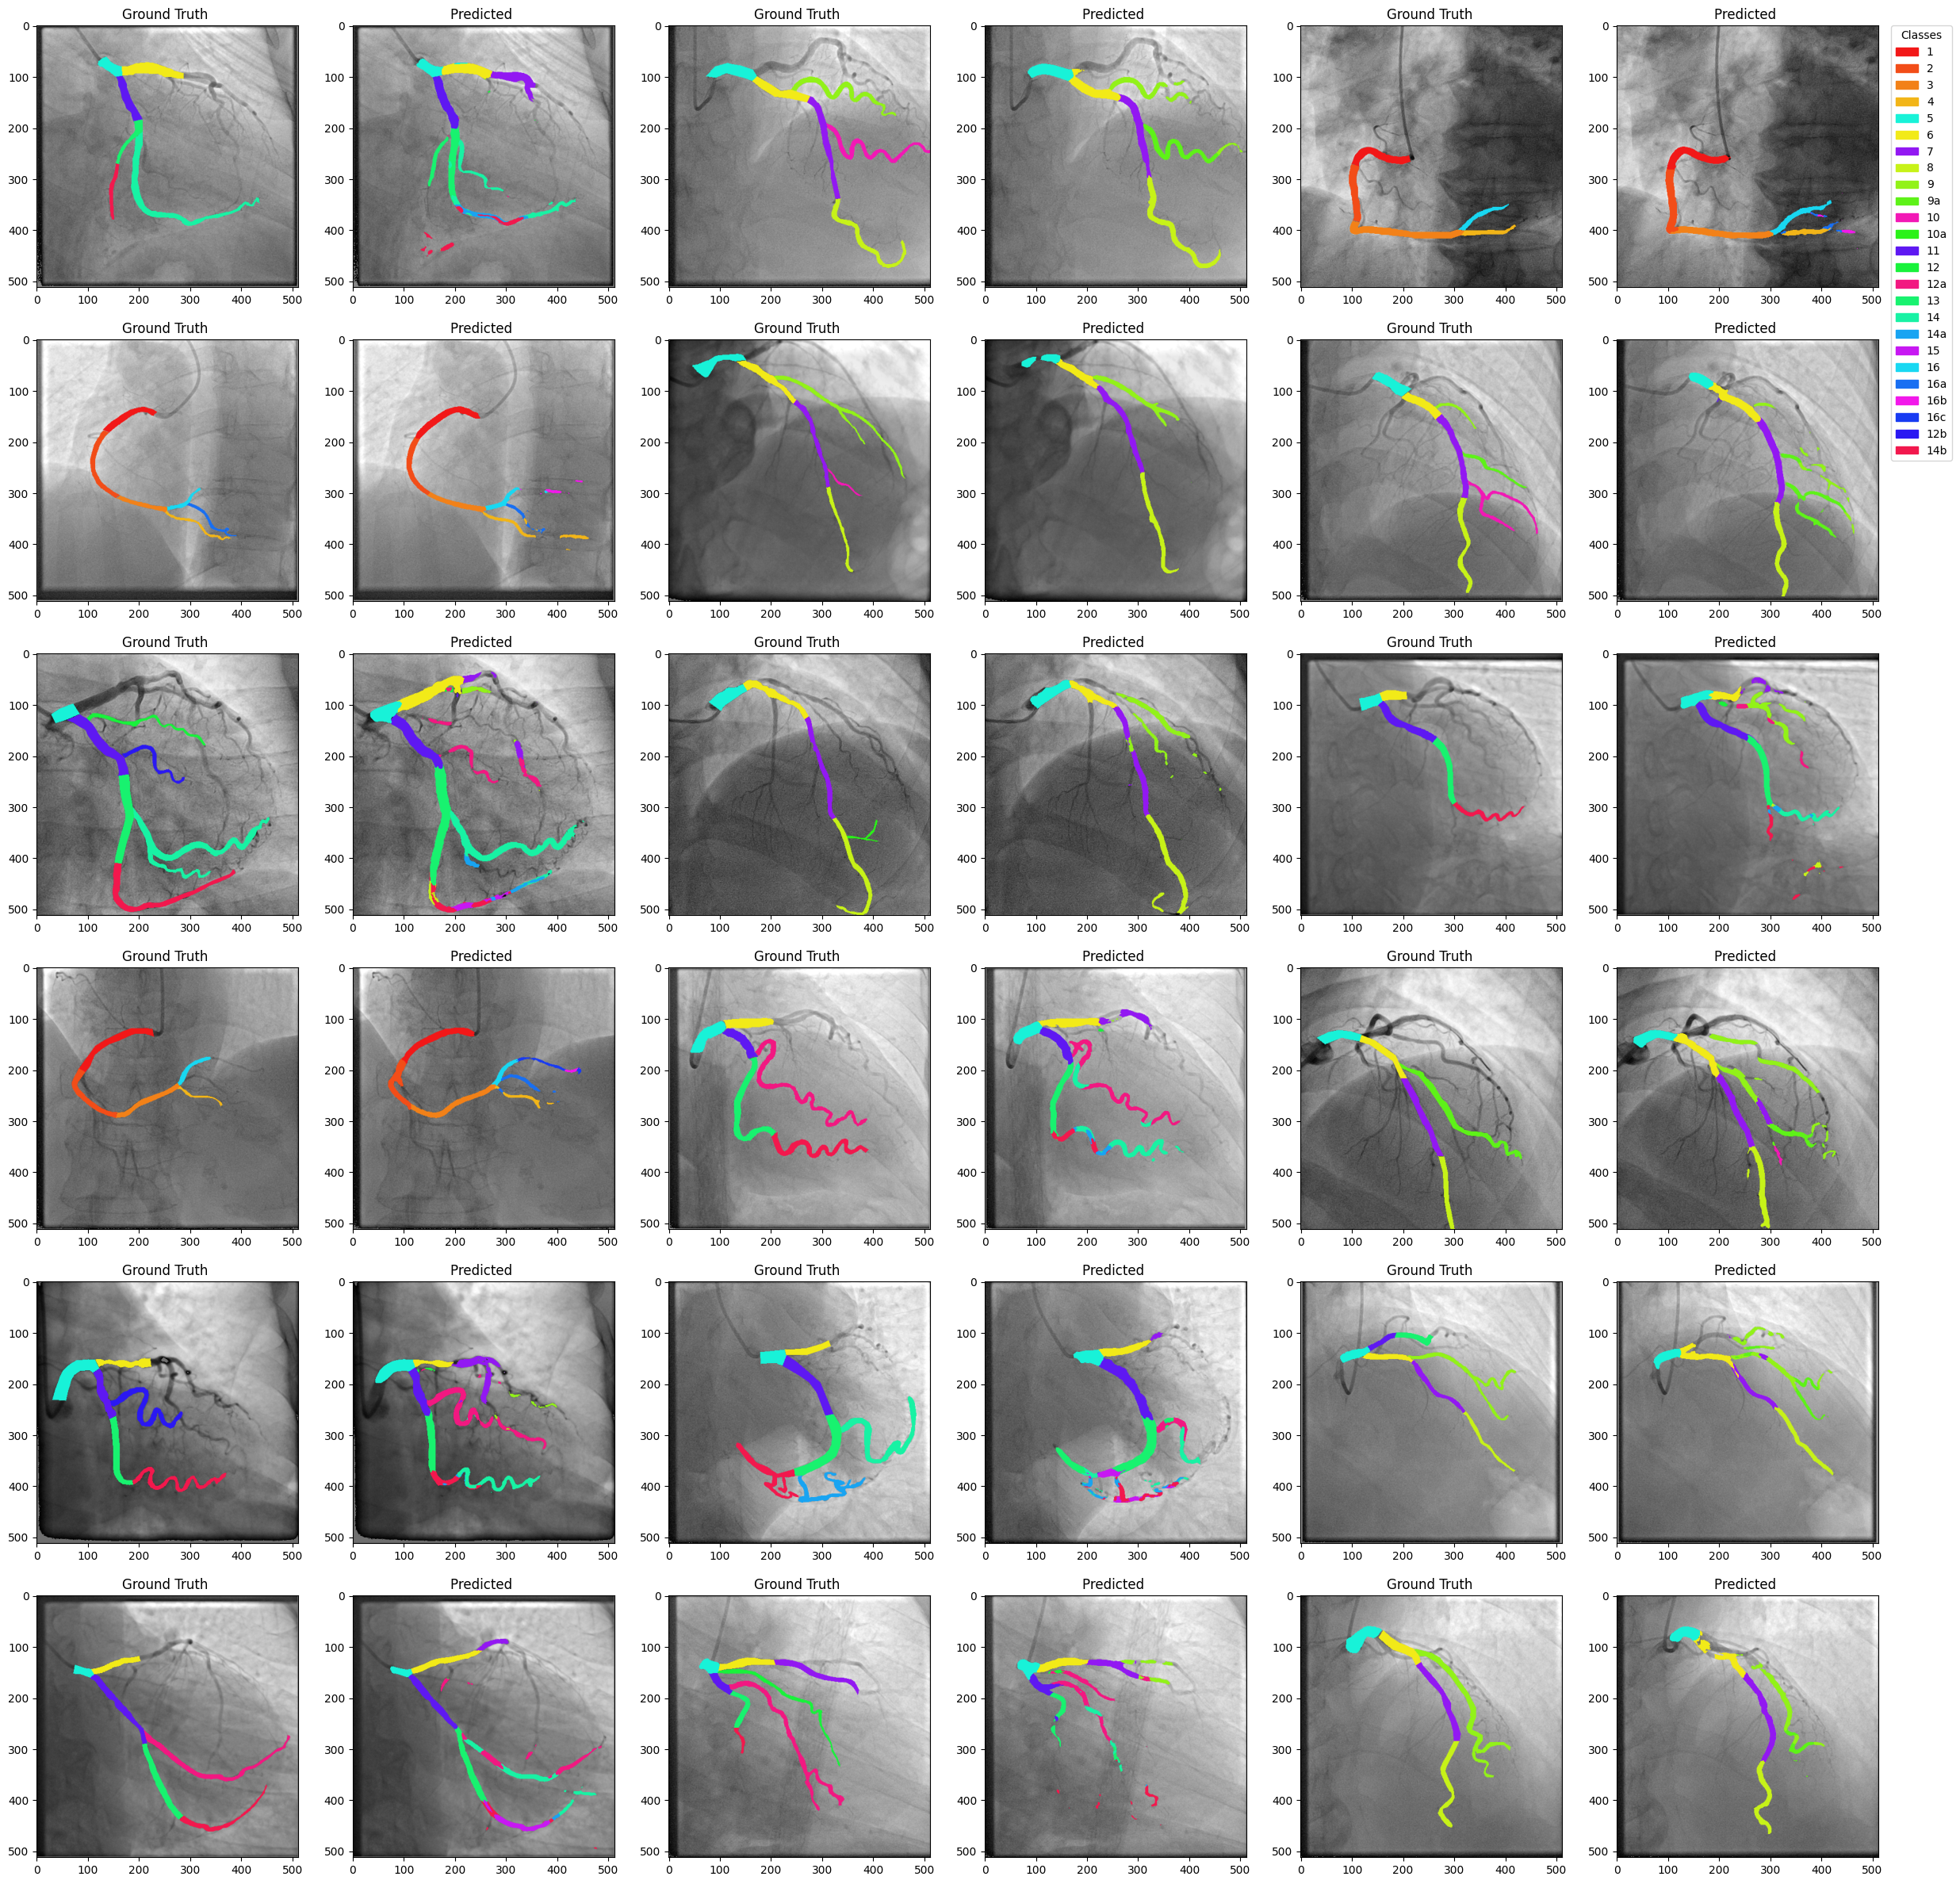

: 

: 

In [ ]:
save_full_report(
    recorder= recorder , 
    output_base_path=args["output_base_path"],
    model=model,
    valid_loader=valid_loader,
    args=args,
    class_map=class_map,
    name=args["name"]
)